In [1]:
#https://github.com/fastai/courses/blob/master/deeplearning1/nbs/lesson4.ipynb



In [11]:
import os

from __future__ import division, print_function
%matplotlib inline
from importlib import reload  # Python 3
import utils; reload(utils)
from utils import *
from keras.layers.merge import dot, add, concatenate

#this warning seems to not effect anything: https://github.com/tensorflow/tensorflow/issues/14182

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [12]:
ratings = pd.read_csv('/media/jma/DATA/ml-latest-small/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [13]:
len(ratings)

100004

In [14]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [15]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

# userId and movieId become ditionary elements with values ranging from 0 to max len 
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

#update to be contiguous integers
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

This is the number of latent factors in each embedding.

In [16]:
n_factors = 50

In [17]:
batch_size =64

In [18]:
np.random.seed = 42

Randomly split into training and validation.

In [19]:
msk = np.random.rand(len(ratings)) < 0.8
print(msk.shape)
trn = ratings[msk]
val = ratings[~msk]

(100004,)


In [20]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(input_dim=n_users, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(input_dim=n_movies, output_dim=n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)
x = dot([u, m], axes=2)
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=batch_size, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80116 samples, validate on 19888 samples
Epoch 1/1
80116/80116 [==============================] - 7s 89us/step - loss: 10.1079 - val_loss: 4.4197


##  Bias

In [21]:
#two seperate input layers, each have only 1 feature, the integer index of the user or movie
user_in = Input(shape=(1,), dtype='int64', name='user_in')
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')


In [22]:
#input_dim: int > 0. Size of the vocabulary, i.e. maximum integer index + 1.
#output_dim: int >= 0. Dimension of the dense embedding.
#input_length: Length of input sequences, when it is constant

u=Embedding(input_dim =n_users, output_dim =n_factors, input_length=1, embeddings_regularizer=l2(1e-4),name='user_embedding')(user_in)
m=Embedding(input_dim =n_movies, output_dim =n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)



#create biases
ub1=Embedding(input_dim =n_users, output_dim =1, input_length=1)(user_in)
mb1=Embedding(input_dim =n_movies, output_dim =1, input_length=1)(movie_in)

ub = Flatten()(ub1)
mb = Flatten()(mb1)

#build NN
x=dot([u, m], axes=-1)
#output shape is (None, 1, 1) so need to flatten to (None, 1) 
x = Flatten()(x)

#add the bias for users and movies 
x = add([x, ub])
x = add([x, mb])



#inputs and outputs (i.e. x)
model = Model(inputs=[user_in, movie_in], outputs= x)

model.compile(Adam(0.001), loss='mse')

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_in (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
movie_in (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        33550       user_in[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 50)        453300      movie_in[0][0]                   
__________________________________________________________________________________________________
dot_3 (Dot

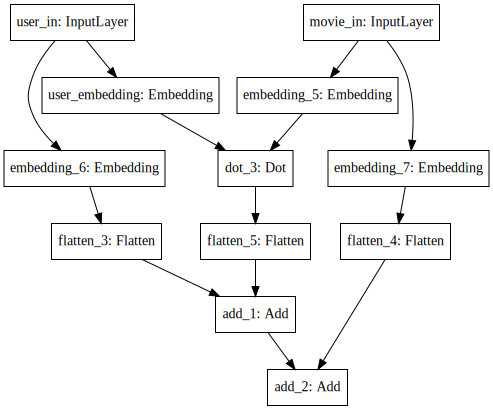

In [23]:
#had to run 
#conda install graphviz
#conda install pydotplus

#https://stackoverflow.com/questions/36886711/keras-runtimeerror-failed-to-import-pydot-after-installing-graphviz-and-pyd

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [24]:
#x inputs are users and movie ids
#y= ratings


model.fit(x=[trn.userId.values, trn.movieId.values], y=trn.rating.values, batch_size=64, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80116 samples, validate on 19888 samples
Epoch 1/5
80116/80116 [==============================] - 7s 85us/step - loss: 8.9720 - val_loss: 3.6132
Epoch 2/5
80116/80116 [==============================] - 7s 83us/step - loss: 2.5941 - val_loss: 2.3329
Epoch 3/5
80116/80116 [==============================] - 7s 85us/step - loss: 1.9907 - val_loss: 2.1221
Epoch 4/5
80116/80116 [==============================] - 7s 87us/step - loss: 1.8279 - val_loss: 2.0160
Epoch 5/5
80116/80116 [==============================] - 7s 86us/step - loss: 1.7302 - val_loss: 1.9435


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [25]:
model.predict([np.array([3]), np.array([6])])

array([[4.3885]], dtype=float32)

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [26]:
x=concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [27]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80116 samples, validate on 19888 samples
Epoch 1/8
80116/80116 [==============================] - 7s 89us/step - loss: 2.3503 - val_loss: 1.2735
Epoch 2/8
80116/80116 [==============================] - 7s 87us/step - loss: 1.6729 - val_loss: 1.1669
Epoch 3/8
80116/80116 [==============================] - 7s 86us/step - loss: 1.3437 - val_loss: 1.0445
Epoch 4/8
80116/80116 [==============================] - 7s 86us/step - loss: 1.1313 - val_loss: 0.9705
Epoch 5/8
80116/80116 [==============================] - 7s 88us/step - loss: 0.9853 - val_loss: 0.9071
Epoch 6/8
80116/80116 [==============================] - 7s 87us/step - loss: 0.9075 - val_loss: 0.8706
Epoch 7/8
80116/80116 [==============================] - 7s 82us/step - loss: 0.8685 - val_loss: 0.8527
Epoch 8/8
80116/80116 [==============================] - 7s 82us/step - loss: 0.8431 - val_loss: 0.8442


This improves on our already impressive accuracy even further!